In [5]:
# Clear environment and import packages
# %reset
import pandas as pd
import numpy as np
import seaborn as sns
# import graphviz
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
from sklearn import preprocessing, tree
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, f1_score, confusion_matrix

In [2]:
#### Import data
data = pd.read_csv("317data_no_att.csv")
data = data.drop("Unnamed: 0", axis=1)
data.head()

,_i_could_find_free_period_products_on_campus_if_i_or_a_friend_needed_one_and_could_not_purchase_products,if_a_stranger_asked_you_for_a_period_product_which_of_the_following_if_any_describe_how_you_would_feel_select_all_that_apply_other_text,have_you_heard_the_term_period_poverty_before,have_you_heard_the_term_period_poverty_before_no,have_you_heard_the_term_period_poverty_before_prefer_not_to_answer,have_you_heard_the_term_period_poverty_before_yes,_period_poverty_is_an_issue_at_my_university,_my_university_adequately_supports_menstruators_on_campus_through_methods_such_as_period_product_access_disposal_facilities_and_education,how_much_do_you_think_you_know_or_do_not_know_about_menstruation,the_hormone_most_directly_causing_menstruation_is,...,aggregate_education3,aggregate_education4,aggregate_education5,aggregate_education6,aggregate_education7,aggregate_education8,aggregate_education_final,aggregate_attitude_final,labels,cup_labels
0,7.0,NaN,0,1,0,0,6,5,4,0,...,0,1,1,0,1,1,4,118,1,0
1,7.0,NaN,0,0,0,1,1,7,2,0,...,0,1,1,1,1,1,6,151,1,0
2,7.0,NaN,0,0,0,1,5,3,3,0,...,1,1,1,1,1,1,8,130,3,1
3,7.0,NaN,0,0,0,1,3,6,2,0,...,1,1,1,1,1,1,8,159,3,1
4,6.0,NaN,0,0,0,1,2,6,2,0,...,0,1,0,0,1,1,4,116,1,0


In [3]:
nan_values = data.isna()
nan_columns = nan_values.any()

columns_with_nan = data.columns[nan_columns].tolist()
columns_with_nan
data = data.fillna(0)

In [4]:
data = data.drop(data.select_dtypes(exclude=[np.number]), axis=1)

In [10]:
corr = data.corr(method='pearson')
corr.to_csv("corr.csv")

In [12]:
# Fit a decision tree regressor

y = data.iloc[:, 205]
x = data.iloc[:, data.columns != "aggregate_attitude_final"]

# Train-test split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state=42)

fit_tree = DecisionTreeRegressor()

In [34]:
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
            "min_samples_split" : [2,4,8,10],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

In [35]:
tuning_model = GridSearchCV(fit_tree,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=0)
tuning_model.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 12],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 4, 8, 10],
                         'min_weight_fraction_leaf': [0.1],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [36]:
new_tree = tuning_model.best_estimator_
new_tree.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=11, max_leaf_nodes=20, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.1,
                      splitter='random')

In [37]:
y_pred = new_tree.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
y_train_tree = new_tree.predict(x_train)
print(mean_squared_error(y_train, y_train_tree))
print(r2_score(y_test, y_pred))

MSE:  581.1901745990442
353.1885119286675
0.15215443622821112


<AxesSubplot:xlabel='labels', ylabel='aggregate_attitude_final'>

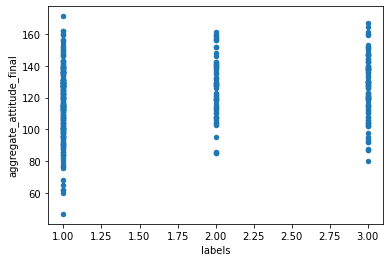

In [38]:
data.plot.scatter(x = 'labels', y = 'aggregate_attitude_final')

In [41]:
x = x.rename(columns={"have_you_used_a_menstrual_cup_in_the_last_year_as_a_result_of_participating_in_the_campus_cup_program_sponsored_by_organi_cup": "campuscup_participant", "what_can_cause_amenorrhea_or_the_absence_of_a_menstrual_period_select_all_that_apply_stress_pregnancy_excessive_exercise" : "amenorrhea_knowledge", "_my_university_adequately_supports_menstruators_on_campus_through_methods_such_as_period_product_access_disposal_facilities_and_education":"university_support_perceived"})

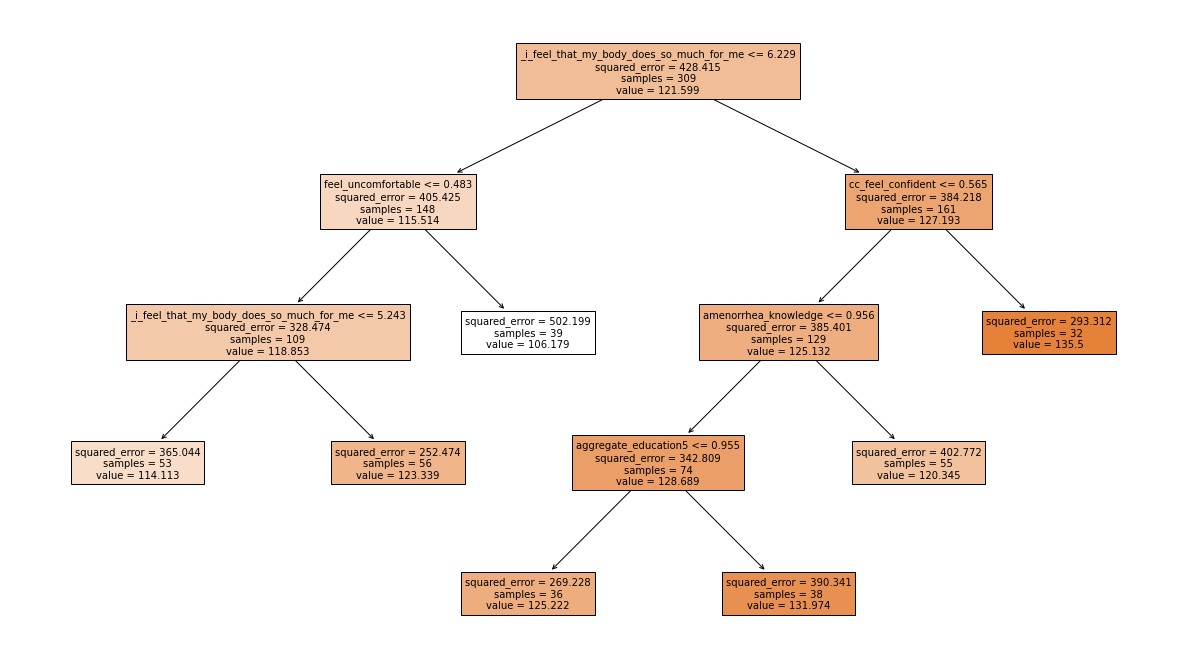

In [42]:
fig = plt.figure(figsize=(21,12))
_ = tree.plot_tree(new_tree, 
                   feature_names=x.columns,  
                   filled=True, fontsize = 10)
plt.savefig('tree_high_dpi', dpi=100)

In [43]:
# Try other regression models to predict attitude score
fit_rand = RandomForestRegressor()

parameters={"max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_samples_split" : [2,4,8,10],
           "min_weight_fraction_leaf":[0.1],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

tuning_model = GridSearchCV(fit_tree,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=0)
tuning_model.fit(x_train, y_train)

new_rand = tuning_model.best_estimator_
new_rand.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=1, min_weight_fraction_leaf=0.1)

In [44]:
new_rand

DecisionTreeRegressor(max_depth=1, min_weight_fraction_leaf=0.1)

In [45]:
y_pred = new_rand.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
y_train_rand = new_rand.predict(x_train)
print(mean_squared_error(y_train, y_train_rand))
print(r2_score(y_test, y_pred))

MSE:  515.9913805000357
350.19282601953347
0.24726703578007148


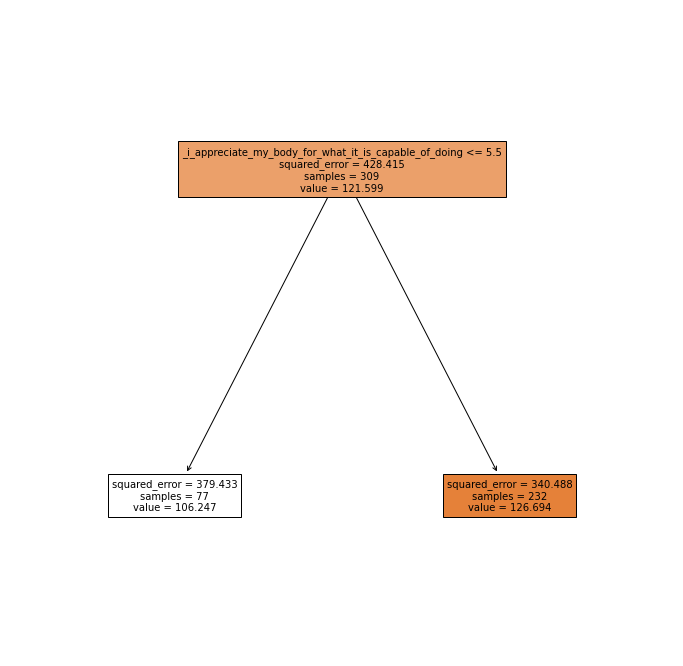

In [46]:
fig = plt.figure(figsize=(12,12))
_ = tree.plot_tree(new_rand, 
                   feature_names=x.columns,  
                   filled=True, fontsize = 10)

In [13]:
# Try some other regression models
from sklearn.metrics import r2_score
# Lasso regression
model_lasso = Lasso(alpha=0.5)
model_lasso.fit(x_train, y_train) 
y_pred_lasso= model_lasso.predict(x_test)
y_train_lasso = model_lasso.predict(x_train)
print(mean_squared_error(y_train, y_train_lasso))
print(mean_squared_error(y_test, y_pred_lasso))
print(r2_score(y_test, y_pred_lasso))

282.5924481163285
401.2241460956203
0.4146905312362189


In [14]:
# Find out variables that were kept by lasso
coef_indices = []
for i in range(len(model_lasso.coef_)):
    if model_lasso.coef_[i] != 0:
        coef_indices.append(i)
for i in coef_indices:
    print(x.columns[i])

_i_could_find_free_period_products_on_campus_if_i_or_a_friend_needed_one_and_could_not_purchase_products
have_you_heard_the_term_period_poverty_before_yes
_my_university_adequately_supports_menstruators_on_campus_through_methods_such_as_period_product_access_disposal_facilities_and_education
how_much_do_you_think_you_know_or_do_not_know_about_menstruation
what_can_cause_amenorrhea_or_the_absence_of_a_menstrual_period_select_all_that_apply_stress_pregnancy_excessive_exercise
_it_is_normal_to_lose_about_a_cup_of_blood_while_menstruating
_it_is_safe_for_menstruators_to_have_sex_while_menstruating
_i_appreciate_my_body_for_what_it_is_capable_of_doing
_i_feel_that_my_body_does_so_much_for_me
do_you_know_your_cervix_height_yes
stranger_confident
stranger_proud
cc_feel_excited
feel_dirty
feel_embarrassed
no_cup_care_clean
aggregate_education_final
labels


In [20]:
for i in range(len(model_lasso.coef_)):
    if model_lasso.coef_[i] != 0:
        print(model_lasso.coef_[i])

0.34769689604889126
0.24716520294062463
0.19229604386372334
0.07068253671079855
-3.8318451181219992
-0.30174488325147236
1.376745260332963
5.169346496500779
0.8827281097650606
0.44941207022299456
3.3849192683318083
1.7996892049015702
1.9527715247498985
-1.613488142289819
-5.768592200256408
-0.985940951190354
0.527907208974944
0.3771298640445221


In [73]:
# Ridge regression
model_ridge = Ridge(alpha=70)
model_ridge.fit(x_train, y_train) 
y_pred_ridge= model_ridge.predict(x_test)
y_train_ridge = model_ridge.predict(x_train)
print(mean_squared_error(y_train, y_train_ridge))
print(mean_squared_error(y_test, y_pred_ridge))
print(r2_score(y_test, y_pred_ridge))

257.5910062140365
382.02169099000383
0.4427032490803492


In [50]:
# ElasticNet
model_en = ElasticNet(alpha=0.5)
model_en.fit(x_train, y_train) 
y_pred_en = model_en.predict(x_test)
y_train_en = model_en.predict(x_train)
print(mean_squared_error(y_train, y_train_en))
print(mean_squared_error(y_test, y_pred_en))
print(r2_score(y_test, y_pred_en))

285.0501628150255
394.8999707938635
0.42391629624129445


In [51]:
# Find out variables that were kept by elastic net
coef_indices = []
for i in range(len(model_en.coef_)):
    if model_en.coef_[i] != 0:
        coef_indices.append(i)
for i in coef_indices:
    print(x.columns[i])

_i_could_find_free_period_products_on_campus_if_i_or_a_friend_needed_one_and_could_not_purchase_products
have_you_heard_the_term_period_poverty_before_no
have_you_heard_the_term_period_poverty_before_yes
_period_poverty_is_an_issue_at_my_university
university_support_perceived
how_much_do_you_think_you_know_or_do_not_know_about_menstruation
the_hormone_most_directly_causing_menstruation_is_progesterone
how_long_is_the_average_menstrual_cycle_21_days
amenorrhea_knowledge
amenorrhea_knowledge
_it_is_normal_to_lose_about_a_cup_of_blood_while_menstruating
_it_is_safe_for_menstruators_to_have_sex_while_menstruating
_menstrual_flow_comes_from_the_bladder
_i_appreciate_my_body_for_what_it_is_capable_of_doing
_i_feel_that_my_body_does_so_much_for_me
do_you_know_your_cervix_height_no
do_you_know_your_cervix_height_yes
do_you_regularly_use_a_menstrual_cup_no
do_you_regularly_use_a_menstrual_cup_yes
campuscup_participant
for_how_long_have_you_been_using_a_menstrual_cup_3_6_months
would_you_recomm

In [52]:
# Simple linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)
pred_test_lr= lr.predict(x_test)
print(mean_squared_error(y_test,pred_test_lr))
y_train_lr = lr.predict(x_train)
print(mean_squared_error(y_train, y_train_lr))
print(r2_score(y_test, pred_test_lr))

1.8863952845791398e+25
151.51444549622272
-2.7518907639032803e+22


In [57]:
x_train.iloc[:,205]

118    1
289    1
193    1
5      1
210    2
      ..
188    1
71     1
106    3
270    3
102    2
Name: labels, Length: 309, dtype: int64

In [58]:
threelabs = x_train.iloc[:,205]
twolabs = x_train.iloc[:,206]

threelabs = threelabs.values.reshape(-1, 1)
twolabs = twolabs.values.reshape(-1, 1)

threelabstest = x_test.iloc[:,205]
twolabstest = x_test.iloc[:,206]

threelabstest = threelabstest.values.reshape(-1, 1)
twolabstest = twolabstest.values.reshape(-1, 1)

minireg = LinearRegression()
minireg.fit(threelabs, y_train)
threepred = minireg.predict(threelabstest)

In [59]:
print(mean_squared_error(y_test, threepred))
print(r2_score(y_test, threepred))

703.2988067053976
-0.02597875761154489


In [80]:
minireg2 = LinearRegression()
minireg2.fit(twolabs, y_train)
twopred = minireg.predict(twolabstest)

In [81]:
print(mean_squared_error(y_test, twopred))
print(r2_score(y_test, twopred))

658.4370546419163
0.03946597826392484


In [3]:
# Reverse engineering a tree: given the data, can we predict the participant segment?
df = pd.read_csv("317cleaned_mod_data.csv")

# Drop all variables that would reveal the participants' segment
df = df.drop("Unnamed: 0", axis=1)
#df = df.drop("labels", axis=1)
#df = df.drop("cup_labels", axis=1)
df = df.drop("do_you_regularly_use_a_menstrual_cup", axis=1)
df = df.drop("do_you_regularly_use_a_menstrual_cup_yes", axis=1)
df = df.drop("do_you_regularly_use_a_menstrual_cup_no", axis=1)
df = df.drop("have_you_used_a_menstrual_cup_in_the_last_year_as_a_result_of_participating_in_the_campus_cup_program_sponsored_by_organi_cup", axis=1)



df.columns

Index(['where_do_you_attend_university_text_american_university',
       'where_do_you_attend_university_text_american_university_2',
       'where_do_you_attend_university_text_appalachian_state_university',
       'where_do_you_attend_university_text_bowdoin_college',
       'where_do_you_attend_university_text_central_penn_college',
       'where_do_you_attend_university_text_george_washington_university',
       'where_do_you_attend_university_text_george_washington_university_2',
       'where_do_you_attend_university_text_georgetown_university',
       'where_do_you_attend_university_text_lane_community_college',
       'where_do_you_attend_university_text_lane_community_college_2',
       ...
       'aggregate_education3', 'aggregate_education4', 'aggregate_education5',
       'aggregate_education6', 'aggregate_education7', 'aggregate_education8',
       'aggregate_education_final', 'aggregate_attitude_final', 'labels',
       'cup_labels'],
      dtype='object', length=294)

In [194]:
df.iloc[:, 127:173]

,have_you_used_a_menstrual_cup_in_the_last_year_as_a_result_of_participating_in_the_campus_cup_program_sponsored_by_organi_cup_no,have_you_used_a_menstrual_cup_in_the_last_year_as_a_result_of_participating_in_the_campus_cup_program_sponsored_by_organi_cup_yes,for_how_long_have_you_been_using_a_menstrual_cup,for_how_long_have_you_been_using_a_menstrual_cup_1_year_3_years,for_how_long_have_you_been_using_a_menstrual_cup_3_6_months,for_how_long_have_you_been_using_a_menstrual_cup_6_months_1_year,for_how_long_have_you_been_using_a_menstrual_cup_less_than_3_months,for_how_long_have_you_been_using_a_menstrual_cup_longer_than_3_years,would_you_recommend_or_not_recommend_a_menstrual_cup_to_another_student,would_you_recommend_or_not_recommend_a_menstrual_cup_to_another_student_definitely_would_not_recommend,...,did_campus_cup_impact_your_university_community_no,did_campus_cup_impact_your_university_community_prefer_not_to_answer,did_campus_cup_impact_your_university_community_yes,have_you_ever_heard_of_menstrual_cups_prior_to_this_study,have_you_ever_heard_of_menstrual_cups_prior_to_this_study_no,have_you_ever_heard_of_menstrual_cups_prior_to_this_study_yes,if_there_were_a_program_at_your_university_offering_free_menstrual_cups_would_you_participate,if_there_were_a_program_at_your_university_offering_free_menstrual_cups_would_you_participate_maybe,if_there_were_a_program_at_your_university_offering_free_menstrual_cups_would_you_participate_no,if_there_were_a_program_at_your_university_offering_free_menstrual_cups_would_you_participate_yes
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
2,0,1,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
3,0,1,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
340,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
341,0,1,1,0,0,0,0,0,1,0,...,0,0,1,1,0,0,1,0,0,0
342,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0


In [4]:
df.drop(df.iloc[:, 127:173], axis=1, inplace=True)
df.head()

,where_do_you_attend_university_text_american_university,where_do_you_attend_university_text_american_university_2,where_do_you_attend_university_text_appalachian_state_university,where_do_you_attend_university_text_bowdoin_college,where_do_you_attend_university_text_central_penn_college,where_do_you_attend_university_text_george_washington_university,where_do_you_attend_university_text_george_washington_university_2,where_do_you_attend_university_text_georgetown_university,where_do_you_attend_university_text_lane_community_college,where_do_you_attend_university_text_lane_community_college_2,...,aggregate_education3,aggregate_education4,aggregate_education5,aggregate_education6,aggregate_education7,aggregate_education8,aggregate_education_final,aggregate_attitude_final,labels,cup_labels
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,4,118,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,6,151,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,8,130,3,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,8,159,3,1
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,4,116,1,0


In [171]:
df.columns.get_loc("cup_sustain")
df.columns.get_loc("no_cup_interest")

229

In [173]:
df.columns.get_loc("aggregate_education1")

150

In [5]:
df.drop(df.iloc[:, 143:229], axis=1, inplace=True)
df.head()

,where_do_you_attend_university_text_american_university,where_do_you_attend_university_text_american_university_2,where_do_you_attend_university_text_appalachian_state_university,where_do_you_attend_university_text_bowdoin_college,where_do_you_attend_university_text_central_penn_college,where_do_you_attend_university_text_george_washington_university,where_do_you_attend_university_text_george_washington_university_2,where_do_you_attend_university_text_georgetown_university,where_do_you_attend_university_text_lane_community_college,where_do_you_attend_university_text_lane_community_college_2,...,aggregate_education3,aggregate_education4,aggregate_education5,aggregate_education6,aggregate_education7,aggregate_education8,aggregate_education_final,aggregate_attitude_final,labels,cup_labels
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,4,118,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,6,151,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,8,130,3,1
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,8,159,3,1
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,1,1,4,116,1,0


In [6]:
df.drop(df.iloc[:, 150:158], axis=1, inplace=True)
df.head()

,where_do_you_attend_university_text_american_university,where_do_you_attend_university_text_american_university_2,where_do_you_attend_university_text_appalachian_state_university,where_do_you_attend_university_text_bowdoin_college,where_do_you_attend_university_text_central_penn_college,where_do_you_attend_university_text_george_washington_university,where_do_you_attend_university_text_george_washington_university_2,where_do_you_attend_university_text_georgetown_university,where_do_you_attend_university_text_lane_community_college,where_do_you_attend_university_text_lane_community_college_2,...,asian,black,white,native,hawaiian,other_race,aggregate_education_final,aggregate_attitude_final,labels,cup_labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,4,118,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,6,151,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,8,130,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,8,159,3,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,4,116,1,0


In [7]:
df.drop(df.iloc[:, 0:33], axis=1, inplace=True)

In [203]:
# Predict labels based on other variables
raw = pd.read_csv("317cleaned_mod_data.csv")
labels = raw["labels"]
cup_labels = raw["cup_labels"]

In [204]:
nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
columns_with_nan
df = df.fillna(0)

In [225]:
x_train, x_test, labels_train, labels_test = train_test_split(df, labels, random_state=42)

In [228]:
x_train, x_test, cuplabels_train, cuplabels_test = train_test_split(df, cup_labels, random_state=42)

In [226]:
model = LogisticRegression(random_state=0)

model.fit(x_train, labels_train)

# Make predictions with testing data
predicted = model.predict(x_test)
# Calculate probabilities as shown in class
probs = model.predict_proba(x_test.to_numpy())

print(confusion_matrix(labels_test, predicted))
print(accuracy_score(labels_test, predicted))

[[31  5 11]
 [ 8  4  5]
 [10  3  9]]
0.5116279069767442


C:\Users\jessl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jessl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [229]:
model = LogisticRegression(random_state=0)

model.fit(x_train, cuplabels_train)

# Make predictions with testing data
predicted = model.predict(x_test)
# Calculate probabilities as shown in class
probs = model.predict_proba(x_test.to_numpy())

print(confusion_matrix(cuplabels_test, predicted))
print(accuracy_score(cuplabels_test, predicted))

[[31 16]
 [16 23]]
0.627906976744186


C:\Users\jessl\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jessl\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [230]:
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, cuplabels_train)

y_pred = clf.predict(x_test)
mse = mean_squared_error(cuplabels_test, y_pred)
print("MSE: ", mse)
print(r2_score(labels_test, y_pred))

MSE:  0.4186046511627907
-2.5637596534187232


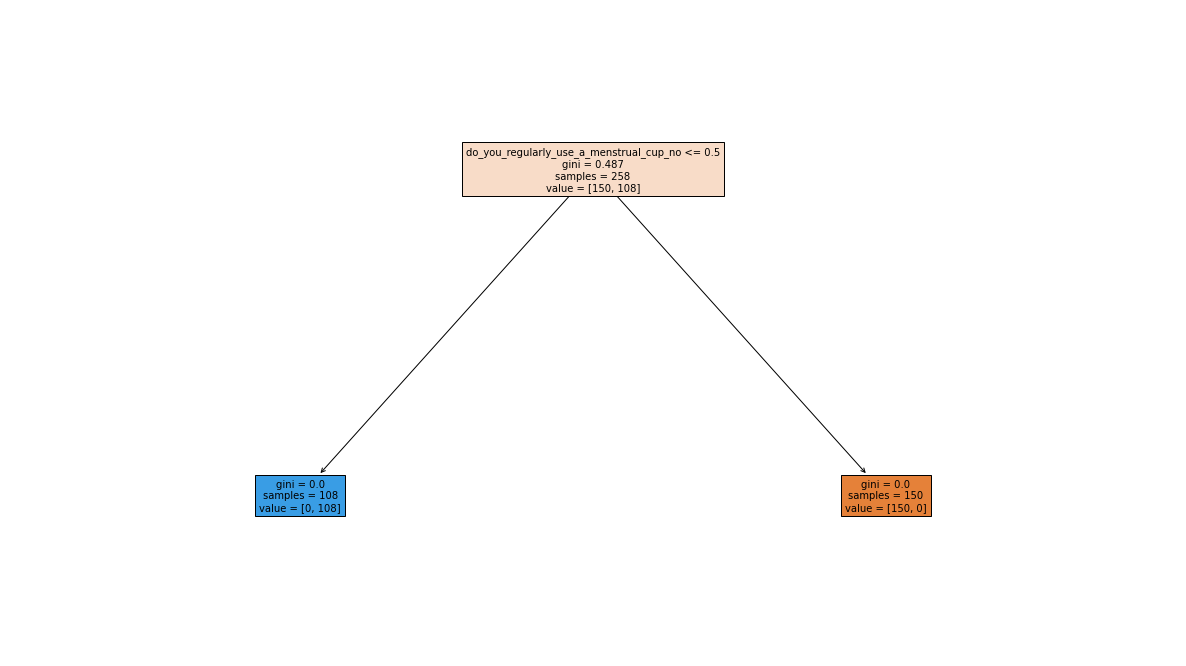

In [222]:
fig = plt.figure(figsize=(21,12))
_ = tree.plot_tree(clf, 
                   feature_names=x.columns,  
                   filled=True, fontsize = 10)
# plt.savefig('tree_high_dpi', dpi=100)